#**Preliminary information**#

This notebook implements training of **model b**. Pre-trained HuggingFace transformer is used as an overall idea.

#**Imports and set up**#

In [1]:
!pip install torchtext --upgrade
!pip install pytorch_lightning
!pip install transformers

Requirement already up-to-date: torchtext in /usr/local/lib/python3.7/dist-packages (0.10.0)
     |████████████████████████████████| 819kB 7.1MB/s 
     |████████████████████████████████| 122kB 22.7MB/s 
     |████████████████████████████████| 10.6MB 17.8MB/s 
     |████████████████████████████████| 645kB 40.9MB/s 
     |████████████████████████████████| 829kB 48.4MB/s 
     |████████████████████████████████| 235kB 47.6MB/s 
     |████████████████████████████████| 1.3MB 42.5MB/s 
     |████████████████████████████████| 143kB 53.8MB/s 
     |████████████████████████████████| 296kB 40.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=9b2d8987ff69bf9005faa9a7f3532a225a315fe5bd8bbacc9fc5f633af885012
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  

In [2]:
#to check if gpu is available
import torch
torch.cuda.is_available()

True

In [3]:
from typing import List, Dict
import json
import torch
from bs4 import BeautifulSoup
import requests
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
import itertools
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch.utils.data import DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#for the repeatability of the experiments
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data and preprocessing**#

In [5]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw2/

Cloning into 'nlp2021-hw2'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 10), reused 18 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [6]:
#datasets paths
restaurants_dev = 'nlp2021-hw2/data/restaurants_dev.json'
restaurants_train = 'nlp2021-hw2/data/restaurants_train.json'

laptops_dev = 'nlp2021-hw2/data/laptops_dev.json'
laptops_train = 'nlp2021-hw2/data/laptops_train.json'

In [7]:
#get dataset from path
def read_dataset(path: str) -> List[Dict]:

    with open(path, "r") as f:
        samples = json.load(f)

    return samples

Different experiemnts with datasets were performed. The function below allows to choose which dataset we are going to use for the training, and which one - for the evaluation.

**r** stands for the restaurants, **l** - for the laptops, and **m** means mixed.

In [23]:
def datasets_setup(mode):

      restaurants_train_samples = read_dataset(restaurants_train)
      restaurants_dev_samples = read_dataset(restaurants_dev)

      laptops_train_samples = read_dataset(laptops_train)
      laptops_dev_samples = read_dataset(laptops_dev)

      if mode == 'rr':
        return restaurants_train_samples, restaurants_dev_samples
      if mode == 'rl':
        return restaurants_train_samples, laptops_dev_samples
      if mode == 'rm':
        return restaurants_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'lr':
        return laptops_train_samples, restaurants_dev_samples
      if mode == 'll':
        return laptops_train_samples, laptops_dev_samples
      if mode == 'lm':
        return laptops_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'mr':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples
      if mode == 'ml':
        return restaurants_train_samples + laptops_train_samples, laptops_dev_samples
      if mode == 'mm':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples + laptops_dev_samples
        
train_samples, dev_samples = datasets_setup('mm')
print(len(train_samples), len(dev_samples))

5000 1086


#**Task b**#


**AspectSentimentDataset** class first performs reframing of a dataset into Pandas dataframe and then applies tokenizer to digitalize representation for the network input. 

Dataframe looks correspondingly to the task b input and consists of 3 columns:

1) sentence as it given, 

2) aspect, 

3) label, 

where aspect is each aspect term from a given set, and labels correspond to multi-class classification problem with 4 classes corresponding to sentiment types (0 $-$ "positive", 1 $-$ "negative", 2 $-$ "neutral", 3 $-$ "conflict"), i.e. for each sentence and each aspect term we want our model to predict on of the sentiments for this aspect term.

Pretrained tokenizer for the **BertLargeUncased** is used.

In [24]:
class AspectSentimentDataset(Dataset):

    def __init__(self, model_name: str, samples: dict):

        data = []
        for i, sample in enumerate(samples):
          sentence = sample["text"]

          aspect_labels = {target[1]: target[2] for target in sample["targets"]}

          for aspect, aspect_label in aspect_labels.items(): 
            data += [{
                "sentence_id": i,
                "sentence": sentence,
                "aspect": aspect,
                "label": aspect_label
                }]

        self.dataframe =  pd.DataFrame(data)
        self.model_name = model_name
        self.inputs = self.apply_tokenizer(self.dataframe)

    def apply_tokenizer(self, dataframe: pd.DataFrame):

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        sentiment_types = ["positive", "negative", "neutral", "conflict"]

        labels_dict = {sentiment: i for (i, sentiment) in enumerate(sentiment_types)}

        labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

        tokenized = tokenizer(list(dataframe.sentence), list(dataframe.aspect), 
                            padding = True, truncation = True, max_length = 512, return_tensors = "pt")
        
        inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
                                                torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
        
        return inputs


    def __len__(self):
      return len(self.dataframe)

    def __getitem__(self, idx):
      return self.inputs[idx]

Pytorch Lightning data module is used for dataloaders. Test and Validation dataloaders both make of use of dev dataset.

In [25]:
class AspectSentimentDataModule(pl.LightningDataModule):

      def __init__(self, model_name, train_samples, dev_samples, batch_size = 16):
        super(AspectSentimentDataModule, self).__init__()

        self.train_samples = train_samples
        self.dev_samples = dev_samples
        self.batch_size = batch_size
        self.model_name = model_name
        self.setup()

      def setup(self, stage = None):

        self.train = AspectSentimentDataset(self.model_name, self.train_samples)
        self.dev = AspectSentimentDataset(self.model_name, self.dev_samples)

      def train_dataloader(self):
        return DataLoader(self.train, batch_size = self.batch_size, shuffle = True)

      def val_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)

      def test_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)

##**Useful prints**##

These subsection is considered for someone who would like to check preprocessing inside dataset class.

In [26]:
# def reframe_dataset(dataset):

#     data = []
#     for i, sample in enumerate(dataset):
#       sentence = sample["text"]

#       aspect_labels = {target[1]: target[2] for target in sample["targets"]}

#       for aspect, aspect_label in aspect_labels.items(): 
#         data += [{
#             "sentence_id": i,
#             "sentence": sentence,
#             "aspect": aspect,
#             "label": aspect_label
#             }]

#     return pd.DataFrame(data)

# train_df = reframe_dataset(train_samples)
# dev_df = reframe_dataset(dev_samples)
# dev_df.head(10)

In [27]:
# def apply_tokenizer(dataframe):

#     tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

#     sentiment_types = ["positive", "negative", "neutral", "conflict"]

#     labels_dict = {sentiment: i for (i, sentiment) in enumerate(sentiment_types)}

#     labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

#     tokenized = tokenizer(list(dataframe.sentence), list(dataframe.aspect), 
#                          padding = True, truncation = True, max_length = 512, return_tensors = "pt")
    
#     inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
#                                             torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
#     return inputs

# train_inputs = apply_tokenizer(train_df)
# dev_inputs = apply_tokenizer(dev_df)
# dev_inputs[:5]

#**Model**#

**AutoModelForSequenceClassification.**from_pretrained(hparams.model_name, num_labels = hparams.num_labels) 

from TRANSFORMERS library is used to load and try different pretrained models of transformers (BertLargeUncased is used for the task b). Apart from this, class gets dataloaders and performs standard training and validation steps, computing some useful metric data.

**AspectSentimentModel** highly duplicates code of **AspectExtractionModel**, except for the fact that now the goal is to solve multi-class classification problem, and therefore softmax is used instead of sigmoid.

In [28]:
class AspectSentimentModel():

      def __init__(self, hparams, device, data_module, *args, **kwargs):
        super().__init__()

        self.lr = hparams.lr
        self.epochs = hparams.epochs
        self.num_labels = hparams.num_labels
        self.numeric_labels = hparams.numeric_labels
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(hparams.model_name, num_labels = hparams.num_labels)
        self.model.to(device)

        self.optimizer = self.configure_optimizers()

        self.train_loader  = data_module.train_dataloader()
        self.dev_loader = data_module.val_dataloader()

      def train(self):

          for epoch in range(self.epochs):

              for idx, (input_ids, attention_mask, labels) in tqdm(enumerate(self.train_loader)):

                  self.optimizer.zero_grad()

                  output = self.model(input_ids = input_ids.to(self.device), attention_mask = attention_mask.to(self.device), labels = labels.to(self.device))

                  loss = output['loss']

                  loss.backward()
                  self.optimizer.step()

              running_loss = 0.0
              steps = 0
              self.confusion = np.zeros([self.num_labels, self.num_labels])

              for idx, (input_ids, attention_mask, labels) in enumerate(self.dev_loader):

                  with torch.no_grad():

                      output = self.model(input_ids = input_ids.to(self.device), 
                                          attention_mask = attention_mask.to(self.device), 
                                          labels = labels.to(self.device))

                      loss, logits = output['loss'], output['logits']

                      self.confusion += confusion_matrix(y_true = labels.flatten().cpu(), 
                                                    y_pred = torch.softmax(logits, -1).argmax(-1).cpu(), 
                                                    labels = self.numeric_labels)

                      running_loss += loss.cpu().numpy()
                      steps += 1

              summary = dict(loss = running_loss / steps, accuracy = self.accuracy())
              print(summary)

          self.save_model()

      
      def get_confusion(self):
        return self.confusion

      def save_model(self):
        torch.save(self.model, f"./absa_b.pt")
        print("Training is finished.")

      def accuracy(self):
        return self.confusion.trace() / self.confusion.sum().sum()

      def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr = self.lr)

#**Hyperparameters and Training**#

In [29]:
class HParamsb():
    model_name = "bert-large-uncased"
    lr = 2e-5
    numeric_labels = [0, 1, 2, 3]
    num_labels = 4
    epochs = 4
hparams_b = HParamsb() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_module = AspectSentimentDataModule(hparams_b.model_name, train_samples, dev_samples, batch_size = 24)
model_b = AspectSentimentModel(hparams_b, device, data_module)
model_b.train()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


{'loss': 0.6511770972739095, 'accuracy': 0.7597042513863216}



{'loss': 0.5925134621236635, 'accuracy': 0.777264325323475}



{'loss': 0.6162957677050777, 'accuracy': 0.7791127541589649}



{'loss': 0.7629578012325193, 'accuracy': 0.7541589648798521}
Training is finished.


#**Test and Predict**#

First, we plot **confusion matrix** to detect "week spots" of classification and inbalancing issues.

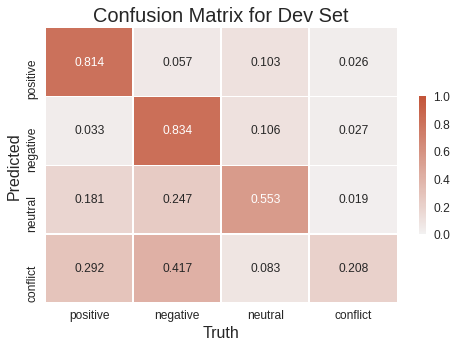

In [30]:
def draw_confusion_matrix(confusion):
            
    sns.set_theme(style="white")
    plt.style.use("seaborn")
    plt.rcParams.update({
        "figure.titlesize": 26,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.title_fontsize": 16,
        "legend.fontsize": 12
    })

    labels = ["positive", "negative", "neutral", "conflict"]

    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)

    X = confusion / confusion.sum(1, keepdims = True)

    sns.heatmap(
        pd.DataFrame(X, index=labels, columns = labels), 
        cmap = cmap, 
        center = 0,
        vmin = 0,
        vmax = 1,
        annot = True, 
        fmt = ".3f",
        linewidths = .5, 
        cbar_kws = {
            "shrink": .5
        }
    )
    ax.set_title("Confusion Matrix for Dev Set")
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()


confusion = draw_confusion_matrix(model_b.get_confusion())     

Differently from the AspectSentimentPredict function in the **a_and_ab_absa** notebook, we compute predictions of sentiments for ground truth aspect terms. AspectSentimentPredict returns **list of sets of pairs** (aspect, sentiment) in order to respect signature of evaluate_sentiment function provided in the GitHub.

**Note:** in this case test_predictions list allows not self-testing, but testing in comparison with ground truth (aspect, sentiment) pairs.

In [31]:
def AspectSentimentPredict(model, device, dataset, hparams_b):

    tokenizer = AutoTokenizer.from_pretrained(hparams_b.model_name)

    sentiment_types = ["positive", "negative", "neutral", "conflict"]

    predictions = []
    test_predictions = []
    for sample in dataset:
    
        sentence = sample["text"]

        aspects = [target[1] for target in sample['targets']]
        num_aspects = len(aspects)

        if aspects == []:
          predictions.append([])
          continue

        tokenized = tokenizer(num_aspects * [sentence], aspects, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.softmax(logits, -1).argmax(-1)
            y_pred = pred.cpu()

            predicted_list = [(aspect, sentiment_types[pred]) for (aspect, pred) in zip(aspects,y_pred)]
        
            true_list = [(aspect[1], sentiment[2]) for (aspect, sentiment) in zip(sample["targets"], sample["targets"])]

            predictions.append(predicted_list)
            test_predictions.append(true_list)
    
    #return zip(predictions, test_predictions)
    return predictions

Provided in GitHub.

In [32]:
def evaluate_sentiment(samples, predictions_b, mode="Aspect Sentiment"):
    scores = {}
  
    sentiment_types = ["positive", "negative", "neutral", "conflict"]

    scores = {sent: {"tp": 0, "fp": 0, "fn": 0} for sent in sentiment_types + ["ALL"]}
    for label, pred in zip(samples, predictions_b):
        for sentiment in sentiment_types:

            pred_sent = {(term_pred[0], term_pred[1]) for term_pred in pred if
                                    term_pred[1] == sentiment}
            gt_sent = {(term_pred[1], term_pred[2]) for term_pred in label["targets"] if
                                    term_pred[2] == sentiment}

            
            print("Prediction")
            print(pred_sent)
            print("Groung truth")
            print(gt_sent)
            print("-"*30)


            scores[sentiment]["tp"] += len(pred_sent & gt_sent)
            scores[sentiment]["fp"] += len(pred_sent - gt_sent)
            scores[sentiment]["fn"] += len(gt_sent - pred_sent)
            
    print("-"*100)

    # Compute per sentiment Precision / Recall / F1
    for sent_type in scores.keys():
        if scores[sent_type]["tp"]:
            scores[sent_type]["p"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fp"] + scores[sent_type]["tp"])
            scores[sent_type]["r"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fn"] + scores[sent_type]["tp"])
        else:
            scores[sent_type]["p"], scores[sent_type]["r"] = 0, 0

        if not scores[sent_type]["p"] + scores[sent_type]["r"] == 0:
            scores[sent_type]["f1"] = 2 * scores[sent_type]["p"] * scores[sent_type]["r"] / (
                    scores[sent_type]["p"] + scores[sent_type]["r"])
        else:
            scores[sent_type]["f1"] = 0

    # Compute micro F1 Scores
    tp = sum([scores[sent_type]["tp"] for sent_type in sentiment_types])
    fp = sum([scores[sent_type]["fp"] for sent_type in sentiment_types])
    fn = sum([scores[sent_type]["fn"] for sent_type in sentiment_types])

    if tp:
        precision = 100 * tp / (tp + fp)
        recall = 100 * tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

    else:
        precision, recall, f1 = 0, 0, 0

    scores["ALL"]["p"] = precision
    scores["ALL"]["r"] = recall
    scores["ALL"]["f1"] = f1
    scores["ALL"]["tp"] = tp
    scores["ALL"]["fp"] = fp
    scores["ALL"]["fn"] = fn

    # Compute Macro F1 Scores
    scores["ALL"]["Macro_f1"] = sum([scores[ent_type]["f1"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_p"] = sum([scores[ent_type]["p"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_r"] = sum([scores[ent_type]["r"] for ent_type in sentiment_types])/len(sentiment_types)

    print(f"{mode} Evaluation\n")

    print(
        "\tALL\t TP: {};\tFP: {};\tFN: {}".format(
            scores["ALL"]["tp"],
            scores["ALL"]["fp"],
            scores["ALL"]["fn"]))
    print(
        "\t\t(m avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (micro)".format(
            precision,
            recall,
            f1))
    print(
        "\t\t(M avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (Macro)\n".format(
            scores["ALL"]["Macro_p"],
            scores["ALL"]["Macro_r"],
            scores["ALL"]["Macro_f1"]))

    for sent_type in sentiment_types:
        print("\t{}: \tTP: {};\tFP: {};\tFN: {};\tprecision: {:.2f};\trecall: {:.2f};\tf1: {:.2f};\t{}".format(
            sent_type,
            scores[sent_type]["tp"],
            scores[sent_type]["fp"],
            scores[sent_type]["fn"],
            scores[sent_type]["p"],
            scores[sent_type]["r"],
            scores[sent_type]["f1"],
            scores[sent_type]["tp"] +
            scores[sent_type][
                "fp"]))

    return scores, precision, recall, f1

In [33]:
scores, precision, recall, f1 = evaluate_sentiment(dev_samples, AspectSentimentPredict(model_b.model, device, dev_samples, hparams_b))

Выходные данные были обрезаны до нескольких последних строк (5000).
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Predi